## Atividade Prática 0
*Aluna: Luiza Carvalho Silveira lcs1@cin.ufpe.br*
### Passo a passo:
1.   Carregar a imagem desejada (em escala de cinza)
2.   Normalizar a imagem (histograma / min-max)
3.   Discretização a imagem no range [0-9]
4.   Aplicar pixel a pixel o mapping de halftone 
5.   Salvar a imagem e verificar a qualidade
6. Compare os resultados obtidos utilizando a imagem original e sua versão com normalização 



# 1. Carregar a imagem desejada (em escala de cinza)


Original Dimensions :  (1412, 1000, 3)


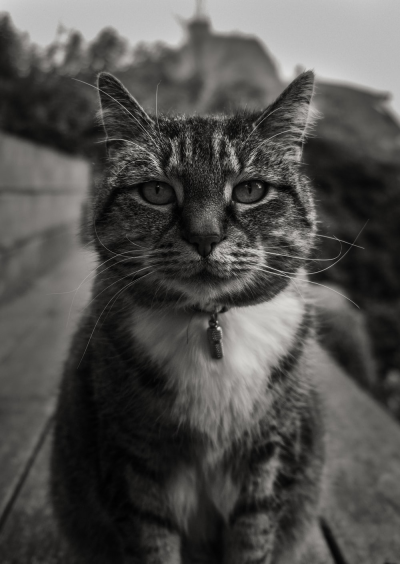

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request as ur
from google.colab.patches import cv2_imshow

img_url = "https://images.unsplash.com/photo-1559485574-35acfb4fcb1b?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1000&q=80"

# Baixando a imagem diretamente pela url e lendo com o opencv
def url_to_image(url):
  resp = ur.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.COLOR_BGR2GRAY)
  return image

image = url_to_image(img_url)

# Diminuindo o tamanho da imagem

print('Original Dimensions : ',image.shape) 
scale_percent = 40 
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)

image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


cv2_imshow(image)


# 2. Normalizar a imagem (com histograma no numpy)

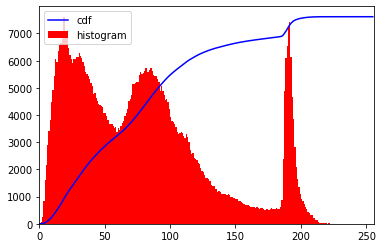

In [ ]:
# Mostrando histograma da imagem atual
hist,bins = np.histogram(image.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(image.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


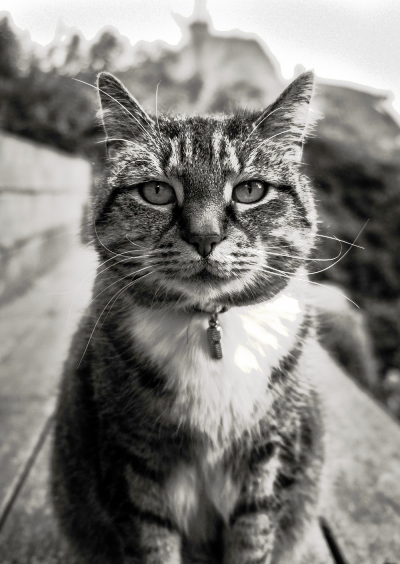

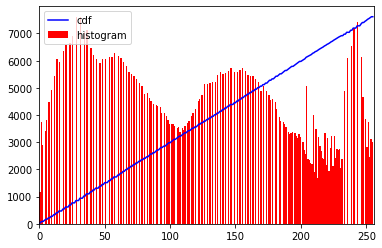

In [ ]:
# Normalizando a imagem com histograma
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[image]

cv2_imshow(img2)

# Histograma da nova imagem

hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


### Normalizando com Histograma no opencv

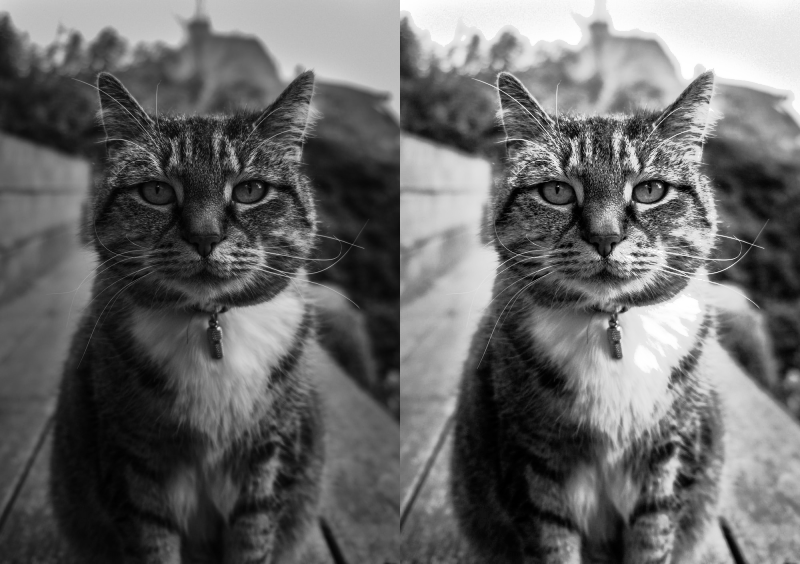

In [ ]:
## Normalizando a imagem no opencv

img = image.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv2_imshow(res)


# 3. Discretização da Imagem

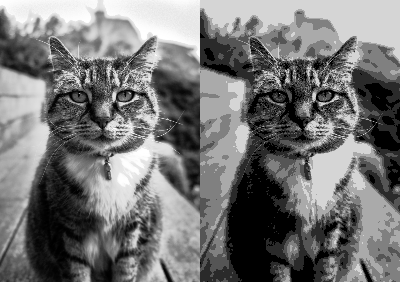

In [ ]:
# para simular a discretizção de uma imagem devemos realizar amostragem e quantização da mesma

def amostragem(img, n):
  amostra = [lin[::n] for lin in img[::n]]
  return np.array(amostra)

def quantizacao_simples(img, K):
  a = np.float32(img)
  bucket = 256 / K
  quantizado = (a / (256 / K))
  return np.uint8(quantizado) * bucket 


amos = amostragem(equ,2)
qtz = quantizacao_simples(amos,6)
res = np.hstack((amos,qtz))
cv2_imshow(res)

# 4. Aplicar pixel a pixel o mapping de halftone 

In [ ]:
from PIL import Image, ImageDraw, ImageStat
from scipy import misc

#Usaremos a biblioteca PIL

def halftone(img, sample, scale, angle=45):
    img_grey = img #.convert('L')   
    channel = img_grey.split()[0]  # Separa os pixels
    channel = channel.rotate(angle, expand=1) 
    size = channel.size[0]*scale, channel.size[1]*scale

    bitmap = Image.new('1', size)
    draw = ImageDraw.Draw(bitmap)

    for x in range(0, channel.size[0], sample):
        for y in range(0, channel.size[1], sample):
            box = channel.crop((x, y, x+sample, y+sample))
            mean = ImageStat.Stat(box).mean[0]
            diameter = (mean/255) ** 0.5
            edge = 0.5 * (1-diameter)
            x_pos, y_pos = (x+edge) * scale, (y+edge) * scale
            box_edge = sample * diameter * scale
            draw.ellipse((x_pos, y_pos, x_pos+box_edge, y_pos+box_edge),
                         fill=255)

    bitmap = bitmap.rotate(-angle, expand=1)
    width_half, height_half = bitmap.size
    xx = (width_half - img.size[0]*scale) / 2
    yy = (height_half - img.size[1]*scale) / 2
    bitmap = bitmap.crop((xx, yy, xx + img.size[0]*scale,
                                  yy + img.size[1]*scale))
    return Image.merge('1', [bitmap])

# Usando halftone em todas as imagens

disc = Image.fromarray(qtz.astype(np.uint8), 'L')
norm = Image.fromarray(equ.astype(np.uint8), 'L')
orig = Image.fromarray(image)


disc_h = halftone(disc, 3, 15)
norm_h = halftone(norm, 3, 15)
orig_h = halftone(orig, 3, 15)



# 5. Salvar a imagem e verificar a qualidade

In [ ]:
from google.colab import drive
from matplotlib.pyplot import imshow

drive.mount('/content/gdrive')
disc_h.save("/content/gdrive/My Drive/img_discretizada_halftone.png")
norm_h.save("/content/gdrive/My Drive/img_normalizada_halftone.png")
orig_h.save("/content/gdrive/My Drive/img_original_halftone.png")


TIMEOUT: ignored

# 6. Comparando 



<Figure size 432x288 with 0 Axes>

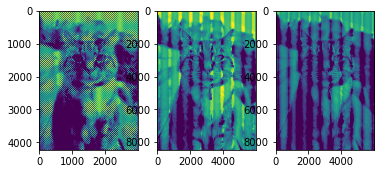

In [ ]:
%matplotlib inline
plt.figure()
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(np.asarray(disc_h))
axarr[1].imshow(np.asarray(norm_h))
axarr[2].imshow(np.asarray(orig_h))


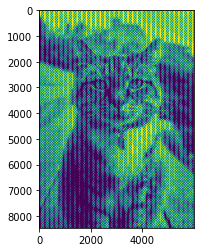

In [ ]:
norm_h = Image.open("/content/gdrive/My Drive/img_normalizada_halftone.png")

%matplotlib inline
imshow(np.asarray(norm_h))

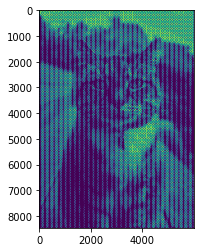

In [ ]:
orig_h = Image.open("/content/gdrive/My Drive/img_original_halftone.png")
%matplotlib inline
imshow(np.asarray(orig_h))

A imagem com normalização acaba se tornando mais nítida possuindo uma variação de tons de cinza maior assim fazendo com que o gato esteja mais destacado e visivel na mesma após a aplicação do halftone


Obs: ao usar o PIL as imagens no colab não aparecem em escala de cinza, no entanto ao serem salvas verifiquei que realmente estão na escala de cinza